# LITERALLY RECOMMENDABLE:
# Using Text Embedding Algorithms in Recommendation Systems

The data for this practical part comes from Kaggle:
https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101/data

It's was originally provided by CI&T and represents a collection of <b>interactions between online users and news articles</b>. Using this dataset, we can simulate building a <b>content recommendation system for some news website</b>.

<b>1) Package Imports</b>

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors

<b>2) Setting some paths and constants.</b>

In [2]:
DIR = '/home/sist/Desktop/wad/data/'
ARTICLES = 'shared_articles.csv'
USERS = 'users_interactions.csv'
GOOGLENEWS = 'GoogleNews-vectors-negative300.bin'
SPECIAL_CHARS = '[^A-Za-z0-9 ]+'

<b>3) Loading data (two CSVs) and joining them.</b>

In [3]:
df_users = pd.read_csv(DIR+USERS)
df_articles = pd.read_csv(DIR+ARTICLES)
df_all = pd.merge(df_users, df_articles, on='contentId', how='inner')

<b>4) Dropping some redundant columns, renaming columns, filtering out non-English samples.</b>

In [4]:
df_all = df_all.drop(['timestamp_y', 'eventType_y'], axis=1)
df_all.columns.values[0] = 'timestamp'
df_all.columns.values[1] = 'eventType'
df_all = df_all[(df_all.lang == 'en') & (df_all.eventType == 'VIEW')].drop_duplicates(['title', 'personId'])

<b>5) Having a look at the cleaned data.</b>

In [5]:
df_all.head().transpose()

,0,2,3,6,9
timestamp,1465413032,1465907360,1465583412,1465320576,1465392977
eventType,VIEW,VIEW,VIEW,VIEW,VIEW
contentId,-3499919498720038879,-3499919498720038879,-3499919498720038879,-3499919498720038879,-3499919498720038879
personId,-8845298781299428018,-108842214936804958,-1443636648652872475,-8020832670974472349,-9009798162809551896
sessionId,1264196770339959068,-2163423831651021975,-3976301106281818872,4338004905404464134,7335613547264158268
userAgent,NaN,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,NaN,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
userRegion,NaN,SP,SP,NaN,SP
userCountry,NaN,BR,BR,NaN,BR
authorPersonId,-1032019229384696495,-1032019229384696495,-1032019229384696495,-1032019229384696495,-1032019229384696495
authorSessionId,-7696592431575292648,-7696592431575292648,-7696592431575292648,-7696592431575292648,-7696592431575292648


<b>6) Computing some statistics to get a feeling for the dataset.</b>

In [6]:
print('Unique articles: '+str(len(df_all.title.unique())))
print('Unique users: '+str(len(df_all.personId.unique())))
print('Unique User-Article Interactions: '+str(len(df_all)))
print('Average read articles per user: '+str(round(len(df_all)/len(df_all.personId.unique()), 2)))

Unique articles: 2113
Unique users: 1643
Unique User-Article Interactions: 25779
Average read articles per user: 15.69


<b>7) Rudimentary preprocessing of article texts:</b>
 - tokenization,
 - removing special characters,
 - lowercasing

In [7]:
df_all.iloc[0].text

"Hiri is the latest startup trying to fix email. Specifically, the Dublin-based company is targeting workplace email with an array of features that aim to nudge users to change their email behaviour for the better. For it isn't email that is necessarily broken but the way we all use and abuse it. Starting with the premise that thoughtless and un-targeted emails fill a very high percentage of your work email inbox, Hiri's headline feature is the ability for recipients to rate each email they receive, which serves as the basis for your own email score or email analytics. You've given a weekly score based on feedback received relating to clarity, brevity, and tone, and the software's rating of your overall email behaviour. The idea, the startup's CEO and co-founder Kevin Kavanagh told me during a call last week, is to get employees thinking about how they currently use email and to begin to change their behaviour for the better. The weekly score also ensures employees don't return to bad 

In [8]:
def preprocess(text):
    tokenized = [word for sent in [re.sub(SPECIAL_CHARS, '', element).split(' ') for 
                                   element in nltk.sent_tokenize(text)] for word in sent]
    lowered = [word.lower() for word in tokenized]
    return lowered

In [9]:
article_texts = [preprocess(text) for text in df_all.text.tolist()]

In [10]:
article_texts[0]

['hiri',
 'is',
 'the',
 'latest',
 'startup',
 'trying',
 'to',
 'fix',
 'email',
 'specifically',
 'the',
 'dublinbased',
 'company',
 'is',
 'targeting',
 'workplace',
 'email',
 'with',
 'an',
 'array',
 'of',
 'features',
 'that',
 'aim',
 'to',
 'nudge',
 'users',
 'to',
 'change',
 'their',
 'email',
 'behaviour',
 'for',
 'the',
 'better',
 'for',
 'it',
 'isnt',
 'email',
 'that',
 'is',
 'necessarily',
 'broken',
 'but',
 'the',
 'way',
 'we',
 'all',
 'use',
 'and',
 'abuse',
 'it',
 'starting',
 'with',
 'the',
 'premise',
 'that',
 'thoughtless',
 'and',
 'untargeted',
 'emails',
 'fill',
 'a',
 'very',
 'high',
 'percentage',
 'of',
 'your',
 'work',
 'email',
 'inbox',
 'hiris',
 'headline',
 'feature',
 'is',
 'the',
 'ability',
 'for',
 'recipients',
 'to',
 'rate',
 'each',
 'email',
 'they',
 'receive',
 'which',
 'serves',
 'as',
 'the',
 'basis',
 'for',
 'your',
 'own',
 'email',
 'score',
 'or',
 'email',
 'analytics',
 'youve',
 'given',
 'a',
 'weekly',
 'score

<b>8) We use titles as unique identifiers of articles. Therefore, we set up a mapping from titles to preprocessed article texts.</b>

In [11]:
title_text = dict(zip(df_all.title.tolist(), article_texts))

<b>9) Furthermore, we want to keep track of what articles a user read. Therefore, we set up another mapping. This time from user IDs to titles. You can see that by building up these mappings, we are beginning to tie article texts to users: user -> title -> text.</b>

In [12]:
user_title = df_all[['personId', 'title']].groupby('personId')['title'].apply(lambda x: x.tolist()).to_dict()
user_title[list(user_title.keys())[0]]

['Google launches Springboard, an AI-powered assistant for its enterprise customers',
 'A new look for Google Play family of apps',
 'Google Is Finally Redesigning Its Biggest Cash Cow: AdWords',
 'Introducing Style Detection for Google Cloud Vision API',
 'Google Cloud Platform adds two new regions, 10 more to come',
 'Platform Overview',
 'Chrome OS now has Material Design for the desktop',
 'Spotify UI built with HTML / CSS - Freebiesbug',
 'Finally, CSS In JavaScript! Meet CSSX - Smashing Magazine',
 'Pull request first - Practical Blend',
 '10 Multipurpose Material Design Themes to Make Your Projects 10 Times Better',
 'Powering a more connected and collaborative enterprise',
 'Top 5 GCP NEXT breakout sessions on YouTube (so far)',
 'Progressive Web App - first introduced on Google I/O | airberlin',
 'Saying �� to Allo and Duo: new apps for smart messaging and video calling',
 'Microsoft to acquire LinkedIn',
 'Vision API - Image Content Analysis',
 'Google is testing a new Materi

<b>10)
Now it's time to have word2vec generate word vectors for words in article texts.</b> There are plenty of pre-trained word2vec models available for download. These models are usually trained on very large corpora, such as entire Wikipedia dumps or the Google News dataset (~3.5 GB), providing them with very accurate word vectors for many cases.

We could train a word2vec model on our own article corpus. However, it's only a few thousand different articles, which isn't really a lot. Luckily, our corpus fits quite well to the <b>Google News dataset</b>, as both corpora contain news articles. Therefore, we <b>load the pretrained model</b> using the popular NLP/Topic-Modeling package gensim. The w2v object can be used like a dictionary. An input word is mapped to a 300 dimensional dense numeric vector.

The pretrained Google News dataset word2vec model can be downloaded here: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

In [13]:
w2v = KeyedVectors.load_word2vec_format(DIR+GOOGLENEWS, binary=True)

<b>11) Next, we set up a function that takes two dictionaries (first_map, second_map) and outputs an aggregated dictionary</b> that uses the keys of first_map as keys. The values of first_map are used as keys in second_map to extract the corresponding values, which are then aggregated (mean) for each key in the output dictionary. In our case, the output dictionary is a mapping from keys (title or userID) to N-dimensional numeric vectors.

In [14]:
def get_vectors(first_map, second_map):
    first_vec  = dict()
    for uid, content in first_map.items():
        temp = list()
        for element in content:
            try:
                temp.append(second_map[element])
            except KeyError:
                pass
        first_vec[uid] = np.mean(temp, axis=0)
    
    return first_vec

In [15]:
title_vec = get_vectors(title_text, w2v)
user_vec = get_vectors(user_title, title_vec)

<b>12) Now we have the appropriate vector for each article (title_vec) and user (user_vec). Next, we ... </b>
 1. define a lookup function
 2. pick a random (target) user and show his 300 dimensional vector
 3. check which articles he read (by title)
 4. search for similar users (user-to-user)
 5. see which articles the user most similar to him read
 6. judge whether these "recommendations" make sense for the target user

In [16]:
def get_most_similar(kind, lookup_id, title_vec, user_vec):

    sim = list()
    
    if kind == 'user-to-user':
        lookup_map = user_vec
        subject_map = user_vec
    elif kind == 'item-to-item':
        lookup_map = title_vec
        subject_map = title_vec
    elif kind == 'item-to-user':
        lookup_map = title_vec
        subject_map = user_vec  
    else:
        raise ValueError('Invalid value for parameter kind.')
        
    for uid, vec in lookup_map.items():
        thisSim = cosine_similarity(vec.reshape(1, -1), subject_map[lookup_id].reshape(1, -1))
        sim.append((uid, thisSim[0][0]))

    return sorted(sim, key=lambda x: x[1], reverse=True)

In [17]:
USERID = 6999578934585823267

In [18]:
user_vec[USERID]

array([ 3.83934267e-02,  1.98046025e-02,  2.60677598e-02,  9.71757025e-02,
       -7.60422423e-02,  6.02996768e-03,  4.85960580e-02, -6.15817048e-02,
        6.00746796e-02,  5.77321127e-02, -5.76591380e-02, -9.08971652e-02,
       -1.36822267e-02,  1.34798186e-02, -8.96785259e-02,  4.95006144e-02,
        3.62423249e-02,  8.74650106e-02, -2.45557330e-03, -6.45062253e-02,
       -2.10532267e-02,  3.12669389e-02, -2.01373361e-02,  7.64014665e-03,
        2.77771689e-02, -7.71125313e-03, -6.85492456e-02,  7.08504692e-02,
        1.18770516e-02, -1.05868597e-02, -2.92205680e-02, -2.96129496e-03,
       -2.78729741e-02, -7.68278632e-03,  9.78257321e-03, -1.75303388e-02,
        8.85547779e-04, -1.31769879e-02,  6.11851998e-02,  3.77062038e-02,
        8.54908973e-02, -1.30251572e-02,  7.79474974e-02,  2.06085276e-02,
       -9.38826799e-03, -4.42517810e-02, -3.02563570e-02,  1.26006836e-02,
        1.24958558e-02,  7.89072737e-03,  4.25554533e-03,  1.83089841e-02,
       -2.89376397e-02, -

In [19]:
user_title[USERID]

['Anti-If: The missing patterns',
 "Beyond Progressive Web Apps Part 2: We Need to Know What's New",
 'Prototypal Object-Oriented Programming using JavaScript',
 "Watch Google's AI master the infamously difficult Atari game Montezuma's Revenge",
 'Wide & Deep Learning: Better Together with TensorFlow',
 'Announcing .NET Core 1.0',
 'Deep Learning for Chatbots, Part 1 - Introduction']

In [20]:
all_similar_users = get_most_similar('user-to-user', USERID, title_vec, user_vec)
all_similar_users[1:11]

[(8874741321583329336, 0.99574673),
 (1163668879480930452, 0.99444306),
 (-8399605302938582500, 0.9943939),
 (2551221442168658664, 0.9943801),
 (1317292353478724560, 0.9943272),
 (-7267769888748948232, 0.99431753),
 (-2979881261169775358, 0.9942804),
 (-6188912942004687815, 0.9941868),
 (670878778036881163, 0.99407476),
 (2290322765105220968, 0.99406415)]

In [29]:
best_id = all_similar_users[1][0]

In [30]:
user_title[USERID]

['Anti-If: The missing patterns',
 "Beyond Progressive Web Apps Part 2: We Need to Know What's New",
 'Prototypal Object-Oriented Programming using JavaScript',
 "Watch Google's AI master the infamously difficult Atari game Montezuma's Revenge",
 'Wide & Deep Learning: Better Together with TensorFlow',
 'Announcing .NET Core 1.0',
 'Deep Learning for Chatbots, Part 1 - Introduction']

In [31]:
user_title[best_id]

['rasbt/python-machine-learning-book',
 'Anti-If: The missing patterns',
 'How will bots make money? Here are 7 business models',
 'Java 8 Best Practices Cheat Sheet',
 'Python Ecosystem for Machine Learning - Machine Learning Mastery',
 'When will AI and NLP actually turn Siri into your best friend?',
 "Watch Google's AI master the infamously difficult Atari game Montezuma's Revenge",
 'Bitcoin Mining, Ethereum Mining, Cloud Mining: 2016 Overview',
 'TPOT: A Python tool for automating data science',
 'The Netflix Tech Blog: Netflix Billing Migration to AWS',
 'Machine Learning is Fun! Part 2',
 'Hello, TensorFlow!',
 'Machine Learning is Fun!',
 'My Top 9 Favorite Python Deep Learning Libraries - PyImageSearch',
 "The Developer's Midlife Crisis: What's Next?",
 'The brilliant mechanics of Pokémon Go',
 'Tabs vs Spaces: How They Write Java at Google, Twitter, Mozilla and Pied Piper | Takipi Blog',
 '10 Modern Software Over-Engineering Mistakes',
 'Serious Business: Should Renewable Ene

<b>13) Check! user-to-user seems to work quite fine! What about item-to-user?</b>

In [24]:
all_similar_items = get_most_similar('item-to-user', USERID, title_vec, user_vec)
all_similar_items[0:10]

[("SyntaxNet in context: Understanding Google's new TensorFlow NLP model | Blog",
  0.98688686),
 ('10 Modern Software Over-Engineering Mistakes', 0.9863461),
 ('Stream processing, Event sourcing, Reactive, CEP... and making sense of it all - Confluent',
  0.9847822),
 ('Stream processing, Event sourcing, Reactive, CEP... and making sense of it all',
  0.9847822),
 ('Machine Learning is Fun! Part 2', 0.984772),
 ('Beyond Progressive Web Apps Part 1', 0.98462063),
 ('Rails vs Django: an in-depth technical comparison', 0.984528),
 ('Hello, TensorFlow!', 0.9842612),
 ('Notes on Reactive Programming Part I: The Reactive Landscape', 0.98320687),
 ('Prototypal Object-Oriented Programming using JavaScript', 0.9832038)]

<b>14) Check again! Also item-to-user seems to work well! Last but not least, what about item-to-item? For this, we sample an item and go through the same steps as for a user.</b>

In [25]:
ITEMID = 'Wall Street Goes Big on Bitcoin Tech'

In [26]:
all_similar_item_to_item = get_most_similar('item-to-item', ITEMID, title_vec, user_vec)
all_similar_item_to_item[1:11]

[('JPMorgan Software Does in Seconds What Took Lawyers 360,000 Hours',
  0.93514276),
 ('The Rise And Growth of Ethereum Gets Mainstream Coverage', 0.93452424),
 ('How This Former Google Engineer Is Bringing Blockchain to Banks',
  0.9293421),
 ('The New Wall Street: Even Big Banks Want Help Navigating Markets',
  0.9291455),
 ("Inside Palantir, Silicon Valley's Most Secretive Company", 0.9284891),
 ("Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's",
  0.92733175),
 ('Blockchain startup R3 cuts fund-raising target to $150 million: source',
  0.92532945),
 ("Lady Gaga's startup Backplane burns out and sells assets", 0.9243519),
 ("Blockchain won't kill banks: Bitcoin pioneer", 0.9226726),
 ('Confirmed: Walmart buys Jet.com for $3B in cash', 0.92205256)]

<b>Makes total sense! Great! Similar articles to a Wall Street/Bitcoin article come from the spectrum of cryptocurrencies, blockchain and banking/investment.</b>

<b>15) Let's use t-SNE to reduce the dimensionality of the vectors and plot users and items.</b> The red dots are item vectors, whereas the blue dots are users. When a user reads more articles, his user vector changes. This means, over time, his "dot" is wandering through the graph. Therefore, also the recommendations made to him will change depending on what article he read and the specific content of that article.

In [27]:
def tsne_plot(mapping):
    
    values = np.asarray(list(mapping.values()))
    labels = list(mapping.keys())
    
    tsne = TSNE(n_components=2, random_state=1)
    new_values = tsne.fit_transform(values)
    
    x, y = [], []
    
    for item in new_values:
        x.append(item[0])
        y.append(item[1])
    
    plt.figure(figsize=(20, 20))
    for ix, _ in enumerate(x):
        if isinstance(labels[ix], int):
            color = 'blue'
        else:
            color = 'red'
        plt.scatter(x[ix], y[ix], color=color, alpha=0.3)
        
    red_patch = mpatches.Patch(color='red', label='articles')
    blue_patch = mpatches.Patch(color='blue', label='users')
    plt.legend(handles=[red_patch, blue_patch], fontsize=16)
    plt.show()

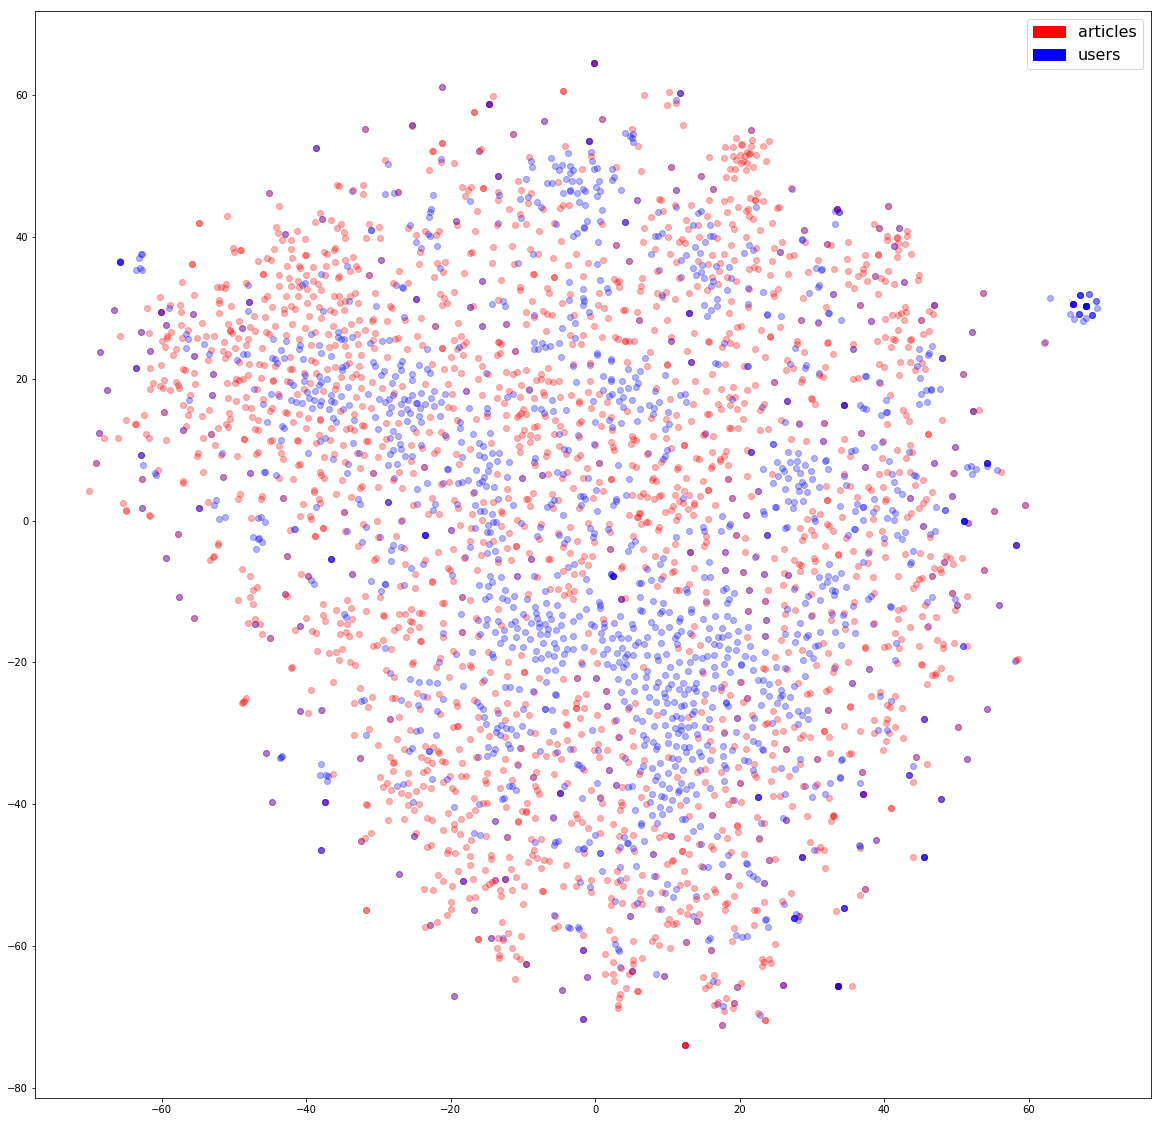

In [28]:
tsne_plot({**title_vec, **user_vec})